# Super restriction factor hypermutation analysis
### Adam S. Dingens
### In collabortation with Mollie McDonnell and Michael Emerman

Analysis performed by Adam Dingens in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in early 2019. Cell culture experiments performed by Mollie McDonnell, and sequencing prep performed by Mollie with Adam's guidance.

Bcinfo csv analysis performed by Kate Dusenbury late 2019.

## Import `Python` modules, define widely used functions
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [75]:
import os
import glob
%matplotlib inline
import pandas as pd
from IPython.display import display, HTML, Image
import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
import dms_tools2.diffsel
import dms_tools2.prefs
from dms_tools2.ipython_utils import showPDF
import string
import Bio.SeqIO
import Bio.Seq
import Bio.SeqRecord
import numpy as np

from plotnine import *

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))


# results will go in this directory
resultsdir = './results_1and1b/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, -1 means all available
ncpus = 2

# do we use existing results or generate everything new?
use_existing = "yes"

Using dms_tools2 version 2.6.4


In [2]:
from dms_tools2.utils import barcodeInfoToCodonVariantTable
from dms_tools2.utils import getSubstitutions
import re
import tempfile
import dms_variants.codonvarianttable
import gzip
import itertools

# Download the sequencing data from the Sequence Read Archive
UPDATE LATER

samples = pd.DataFrame.from_records(
#new data published here for 1-18
        [('BG505_mut_virus_rep3d_1-18-4ug','SRR10014244'),
         ('BG505_mut_virus_rep3d_1-18-8ug','SRR10014243'),
         ('BG505_mut_virus_rep2d_1-18-4ug','SRR10014242'),
         ('BG505_mut_virus_rep2d_1-18-8ug','SRR10014241'),
         ('BG505_mut_virus_rep2d','SRR10014240'),
         ('BG505_mut_virus_rep3d','SRR10014239'),
#Data on VRC01 and 3BNC117 from Dingens et al Immunity 2019 
#Here, I do not download the data on 10-1074 and pooled 10-1074/3BNC117. While I look at this data briefly for one analysis, I simply download the analyzed files from github rather than redoing all analyses. However these can be downloaded and anaylzed in parallel by uncommentin the relevant lines below. 
         ('BG505_mut-virus-rep1b','SRR7693968'),
         ('BG505_mut-virus-rep2b-3BNC117-4ug','SRR7693969'),
         ('BG505_mut-virus-rep1-VRC01-11ug','SRR7693971'),

         ('BG505_mut-virus-rep3','SRR7693976'),
         ('BG505_mut-virus-rep3-3BNC117-1-1ug','SRR7693977'),
         ('BG505_mut-DNA-rep1','SRR7693986'),
         ('BG505_mut-DNA-rep3','SRR7694021'),
         ('BG505_mut-virus-rep2b','SRR7694018'),
         ('BG505_wt-DNA-rep3','SRR7694017'),
         ('BG505_mut-virus-rep2-VRC01-8ug','SRR7694015'),

         ('BG505_mut-virus-rep1b-3BNC117-4ug','SRR7694006'),
         ('BG505_mut-virus-rep3b-3BNC117-4ug','SRR7694005'),
         ('BG505_mut-virus-rep3b','SRR7694003'),
         ('BG505_mut-DNA-rep2','SRR7694002'),
         ('BG505_wt-DNA-rep2','SRR7693998'),
         ('BG505_mut-virus-rep2','SRR7693997'),
         ('BG505_mut-virus-rep3-VRC01-tr2-11ug','SRR7693996'),
         ('BG505_mut-virus-rep3-VRC01-11ug','SRR7693992'),
         ('BG505_mut-virus-rep2-VRC01-11ug','SRR7693991'),
         ('BG505_mut-virus-rep2b-3BNC117-3ug','SRR7693990'),
         ('BG505_wt-DNA-rep1','SRR7693989'),
         ('BG505_mut-virus-rep1','SRR7693987')],
        columns=['name', 'run']
        )


fastqdir = './results/FASTQ_files/'
if not os.path.isdir(fastqdir):
    os.mkdir(fastqdir)
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            ),
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

## Define samples from FASTQ_files

R1fastqfilelist_df = pd.read_csv("./data/samples.csv", header =0)
display(HTML(R1fastqfilelist_df.to_html(index=False)))

In [3]:
samplenames = ["PLASMIDCTRL", "NoA3_1", "A3G_1", "A3C_1", "A3CE68A_1", "COTD_1", "COTDE254A_1", "COTDE68AE254A_1", "I188_1", "I188E68A_1", "COII_1", "COIIE68AE254A_1", "NoA3_2", "A3G_2", "A3C_2", "A3CE68A_2", "COTD_2", "COTDE254A_2", "COTDE68AE254A_2", "I188_2", "I188E68A_2", "COII_2", "COIIE68AE254A_2"]
R1_df = pd.DataFrame({'name':samplenames})

R1_df["name"] = R1_df['name'].str.replace("_", "-")
R1_df["R1"] = R1_df['name'].astype(str) + "_R1.fastq.gz"
print(R1_df)

INFO:numexpr.utils:Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


               name                           R1
0       PLASMIDCTRL      PLASMIDCTRL_R1.fastq.gz
1            NoA3-1           NoA3-1_R1.fastq.gz
2             A3G-1            A3G-1_R1.fastq.gz
3             A3C-1            A3C-1_R1.fastq.gz
4         A3CE68A-1        A3CE68A-1_R1.fastq.gz
5            COTD-1           COTD-1_R1.fastq.gz
6       COTDE254A-1      COTDE254A-1_R1.fastq.gz
7   COTDE68AE254A-1  COTDE68AE254A-1_R1.fastq.gz
8            I188-1           I188-1_R1.fastq.gz
9        I188E68A-1       I188E68A-1_R1.fastq.gz
10           COII-1           COII-1_R1.fastq.gz
11  COIIE68AE254A-1  COIIE68AE254A-1_R1.fastq.gz
12           NoA3-2           NoA3-2_R1.fastq.gz
13            A3G-2            A3G-2_R1.fastq.gz
14            A3C-2            A3C-2_R1.fastq.gz
15        A3CE68A-2        A3CE68A-2_R1.fastq.gz
16           COTD-2           COTD-2_R1.fastq.gz
17      COTDE254A-2      COTDE254A-2_R1.fastq.gz
18  COTDE68AE254A-2  COTDE68AE254A-2_R1.fastq.gz
19           I188-2 

## Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [4]:
!pwd


/fh/fast/bloom_j/computational_notebooks/kdusenbu/2019/SuperRFs/SuperRestrictionFactor_Hypermutation


In [5]:
#first, initial fastqdir ='../../../../SR/ngs/illumina/bloom_lab/190913_M03100_0478_000000000-CKT45/Data/Intensities/'
#these are in: "./FASTQ_files_initialMiseqOnly/"

#then the post rnd2 samples were repooled and sequenced again. These additional reads can thus simple be added to the existing reads. I did this by concatenating all reads from both runs into single fastq files, putting them in the same fastq file
#second miseq to be added with initial miseq run. These are in:
# fastqdir = "./FASTQ_files/"

fastqdir = "../../../../adingens/2019/SuperRes_Hypermut/FASTQ_files"

#Mollie also redid rnd2? and resquenced. These read CANNOT be added to the above reads before error correction, as molecules were tagged in spereate PCR rxns?
#however, in the future, the error corrected mutation counts could be summed together and then analyzed. 
#For now, I put these reads in a seperate fastqdir:
#miseq run: 191104_M04866_0302_000000000-CNB5P
#these are in: "./FASTQ_files_exp2/"


In [6]:
refseq = './data/Bru_Pol.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['205,504,35,34']) #was 204,504,34,34 #these need to be updated 179,529,25,25


# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1_df[['name', 'R1']].to_html(index=False)))
R1_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

#we will only look at sites sequenced
sitemaskfile = "./data/sitemask.csv"

Here is the batch file that we write to CSV format to use as input:


name,R1
PLASMIDCTRL,PLASMIDCTRL_R1.fastq.gz
NoA3-1,NoA3-1_R1.fastq.gz
A3G-1,A3G-1_R1.fastq.gz
A3C-1,A3C-1_R1.fastq.gz
A3CE68A-1,A3CE68A-1_R1.fastq.gz
COTD-1,COTD-1_R1.fastq.gz
COTDE254A-1,COTDE254A-1_R1.fastq.gz
COTDE68AE254A-1,COTDE68AE254A-1_R1.fastq.gz
I188-1,I188-1_R1.fastq.gz
I188E68A-1,I188E68A-1_R1.fastq.gz


In [7]:

#here, we need to allow for a large number of mismatches if the sequence was in fact hypermutated

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 17 \
        --fastqdir {fastqdir} \
        --maxmuts 33 \
        --sitemask {sitemaskfile} \
        --ncpus {ncpus} \
        --bcinfo \
        --bcinfo_csv \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")

# need to edit

# Kate picked a `maxmuts` of 33. There are 100 possible codons that could be mutated, so that's a max of about one third of the codons being mutated.
# When `maxmuts` was 50, there was a cluster of reads in all samples with ~100 substitutions that seemed to come from missaligning. 



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Now we look at the summary plots created by `dms2_batch_bcsubamp`. 
All of these files are found in the directory specified by --outdir, and with the prefix specified by summaryprefix. 
So we define them using this plot prefix plus the suffix for each plot.
Note that these files all refer to sites in sequential 1, 2, ... numbering of the BF520 sequence.

In [8]:
countsplotprefix = os.path.join(countsdir, 'summary')

The `*_readstats.pdf` plot below shows the statistics on the reads. This plot shows that most of the reads were retained, and a small fraction discarded because of low-quality barcodes. None failed the Illumina filter as those were already filtered out those when we downloaded from the SRA.

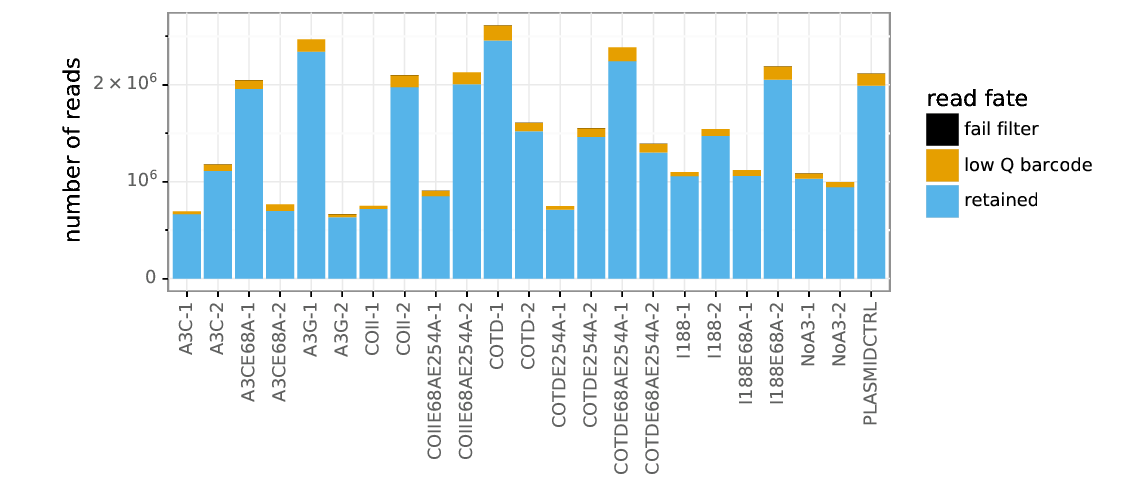

In [9]:
showPDF(countsplotprefix + '_readstats.pdf', width=600)

The `*_readsperbc.pdf` plot below shows how many times different barcodes were observed for each sample. Barcodes need to be observed multiple times to be useful for barcoded-subamplicon sequencing error correction.

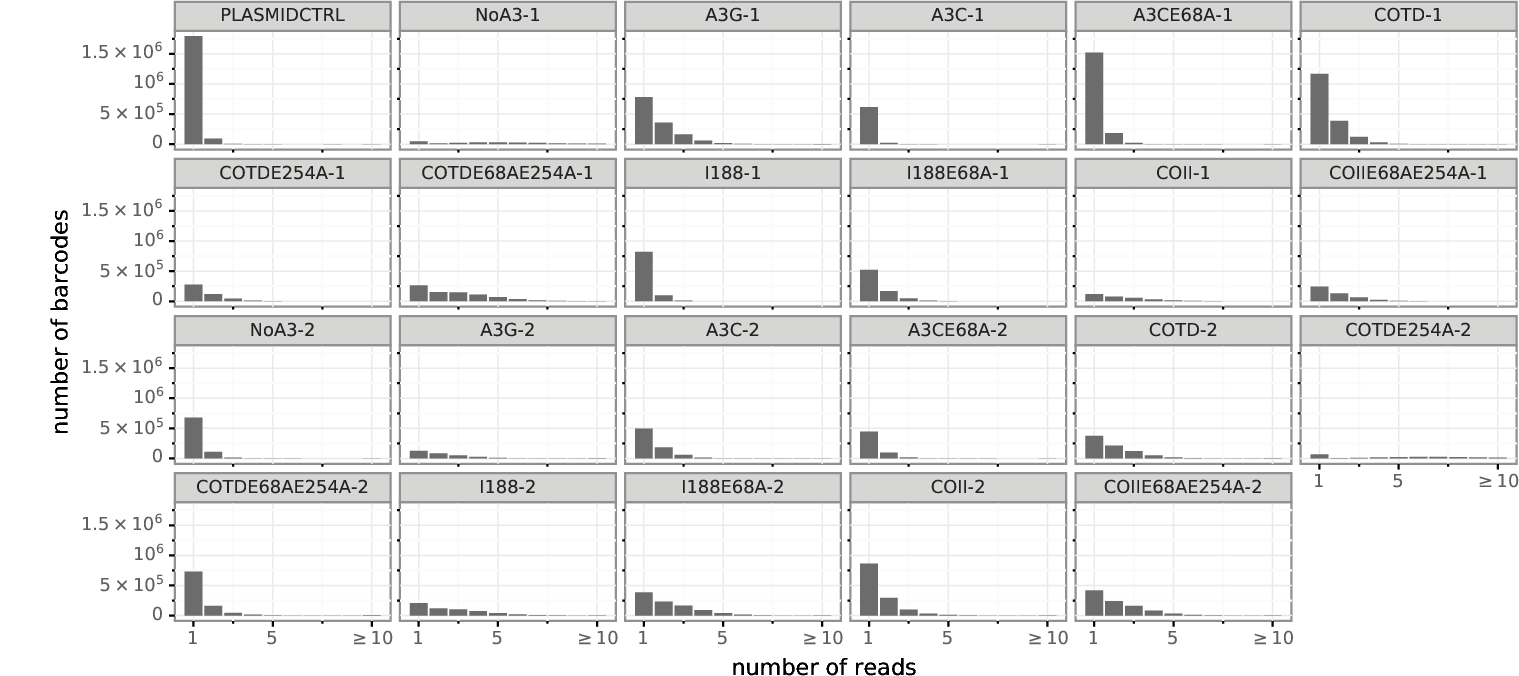

In [10]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` plot below shows statistics on the barcodes. Some of the barcodes had to be discarded because they had too few reads (these are the single-read barcodes in the plot above), a small fraction with adequate reads were not alignable, and the rest aligned to the Env gene properly.
This plot and the one above suggest that probably could have gotten additional depth by sequencing more, since then we would have had more barcodes with multiple reads.

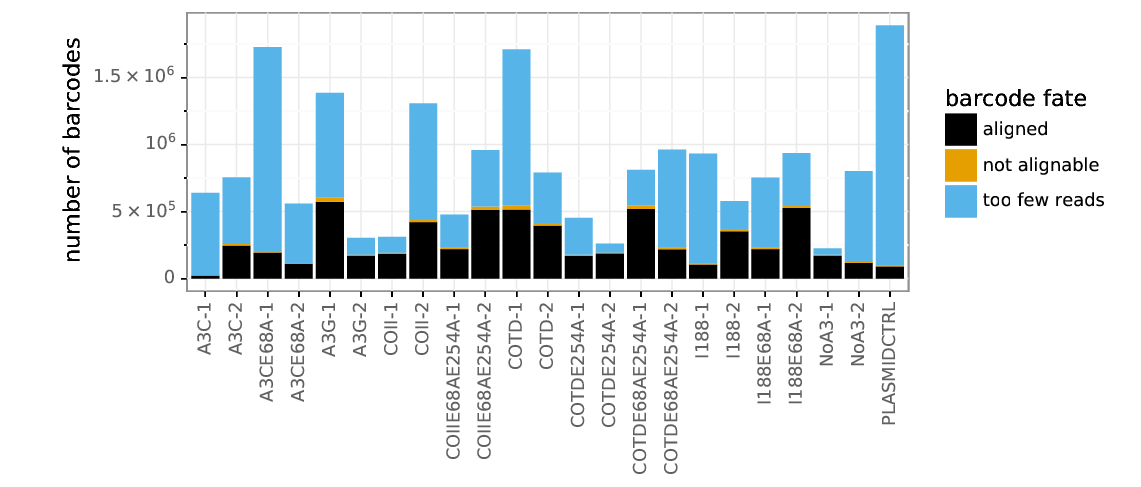

In [11]:
showPDF(countsplotprefix + '_bcstats.pdf', width=600)

The `*_depth.pdf` plot below shows the depth (number of called codons) at each site in the gene. 
For most of the samples, the depth across the gene is fairly uniform, indicating that the subamplicons were pooled fairly evenly.  
Note that some samples (in particular the mock samples) were intentionally sequenced to higher depth than the antibody-selected samples, as we expect to see more diversity in the mock samples. 
Note that the gene was not sequenced past codon site 691, and so there is no coverage there.

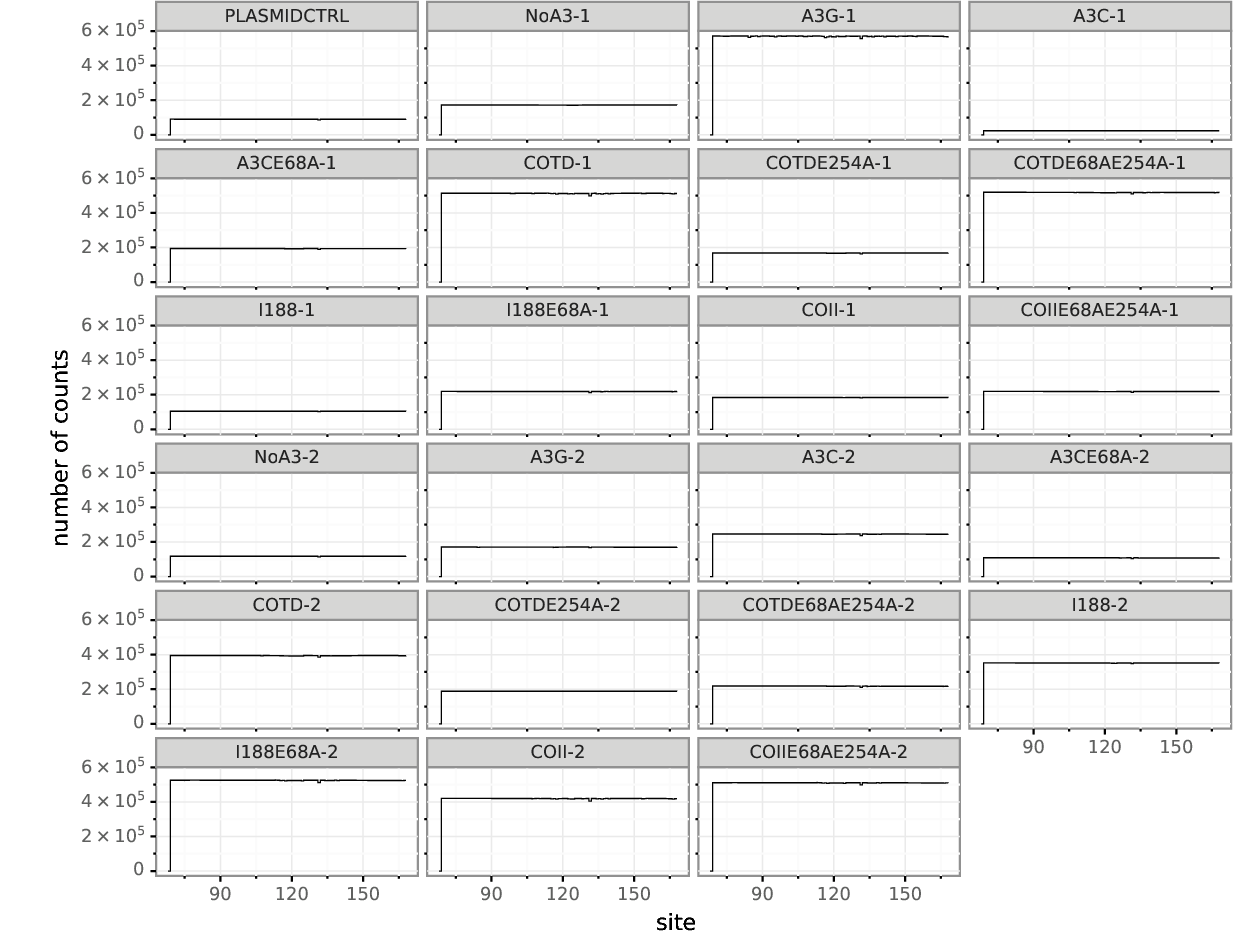

In [12]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` plot below shows the per-codon frequency of mutations at each site. 
For each antibody-selected sample, we see a few sites of clear peaks in mutation frequency. 
These peaks tend to occur at the same sites in different replicates, and so presumably represent the sites where antibody-escape mutations are selected. 
There are no such peaks for the mock sample since there is no antibody selection to favor specific mutations.
Note also that the gene was not mutagenized or sequenced past codon site 691, so there are no mutations there.

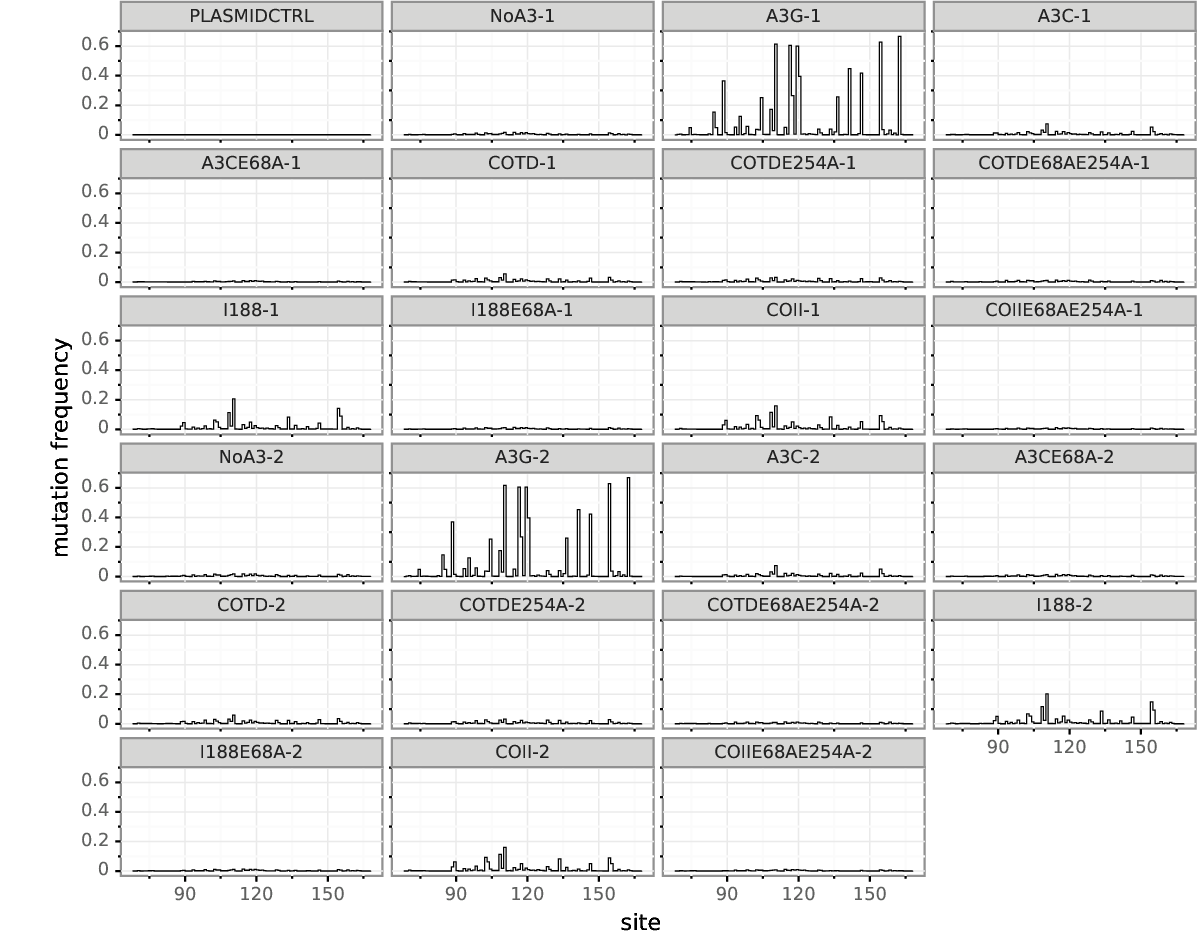

In [13]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_codonmuttypes.pdf` plot below shows the per-codon frequency of nonsynonymous, synonymous, and stop codon mutations across the entire gene. 

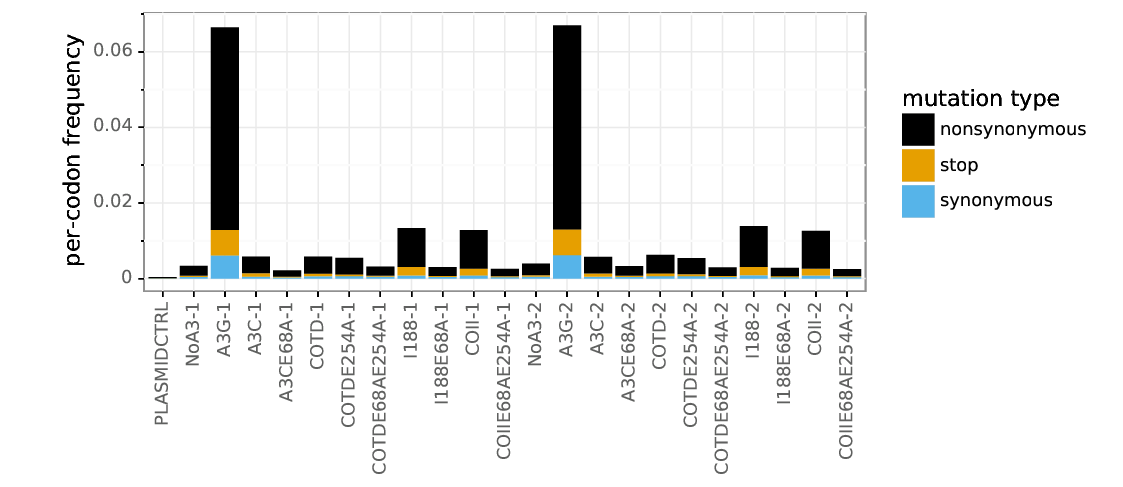

In [14]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=600)

The `*_codonntchanges.pdf` plot below shows same data as above but categorizes codon mutations by the number of nucleotides that are changed (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

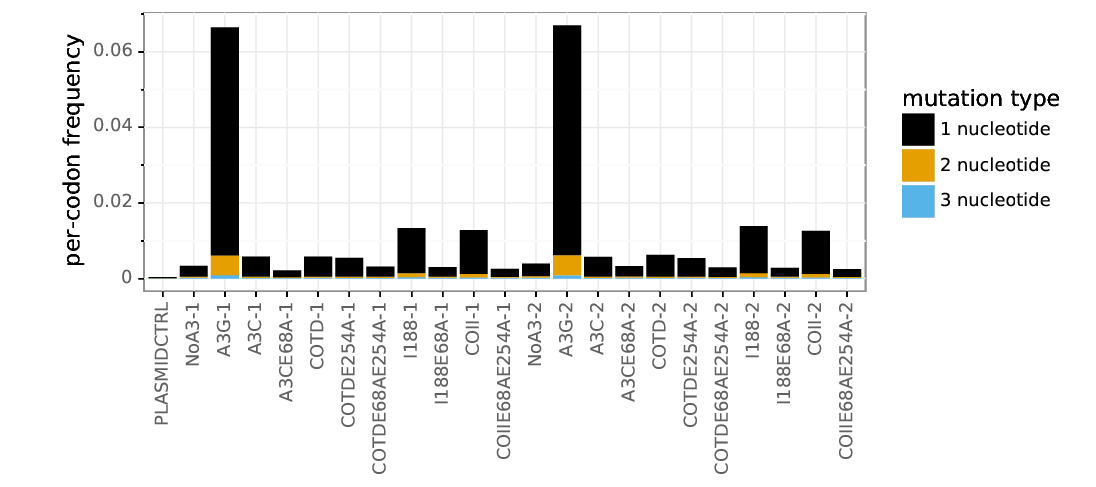

In [15]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=600)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). There is not much oxidative damage in the samples plotted below, which mostly have a fairly even distribution of nucleotide changes.

We do see that transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions). This is expected, since [PCR based sources of mutations are expected to preferentially introduce transitions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3720931/). 

This plot would also be important to examine any sign of APOBEC hypermutation (also G <-> A, with preferences for specific motifs) occuring in the HIV genome. One of the reasons we selected the SupT1.R5 cell line was because [there is very little of the APOBEC proteins expressed in  a subclone of SupT1 cells](https://www.ncbi.nlm.nih.gov/pubmed/20308164). In the viral samples, there does appear to be an increase in G to A and C to T mutations. However, we passaged WT virus in these cells and confirmed there were not signs of extensive APOBEC hypermutation in hotspot motifs via deep sequencing of env after passaging. Thus, we do not think there is extensive APOBEC hypermutation in our data, and this increase certain types of mutations in the viral samples is likely due to bias in the viral reverse transcription.

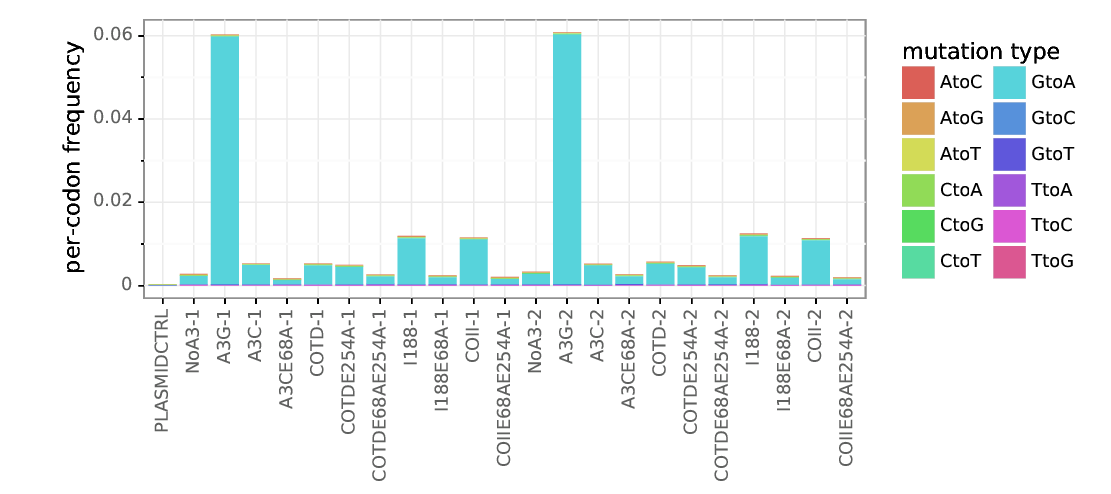

In [16]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

# Analyze `bcinfo.csv.gz` output

The analysis immediately belwo uses the `.csv` output of the `bcinfo file` and makes a heatmap of mutation motifs. 

In [17]:
NTS = ('A', 'C', 'T', 'G', 'N')

def getSubstitutions_Nokay(mutant, wildtype):
    """Get space delimited string of substitutions

    Args:
        `wildtype` (str):
             The wildtype sequence
        `mutant` (str):
             The mutant sequence
    Returns:
        A space delimited string of substitutions present in the
        mutant sequence

    >>> getSubstitutions('AGT', 'TGT')
    'A1T'
    >>> getSubstitutions('AAGTAACGA', 'ATCTAACGA')
    'A2T G3C'
    """
    if mutant == 'None':
        return None
    elif len(wildtype) != len(mutant):
        print(wildtype)
        print(mutant)
        raise ValueError('wildtype and mutant must be same length')
    subs = []
    for site in range(len(wildtype)):
        wt = wildtype[site]
        mut = mutant[site]
        if mut == 'N':
            continue
        if wt not in NTS:
            raise ValueError (f"Invalid wt nucleotide {wt} at site {site+1}")
        if mut not in NTS:
            raise ValueError (f"Invalid mutant nucleotide {mut} at site {site+1}")
        if wt!=mut:
            pos = str(site + 1)
            subs.append(f"{wt}{pos}{mut}")
    subs = ' '.join(subs)

    return subs

In [18]:
NTS_noN = 'ACTG'
def motif_counts(seq):
    motif_counts = {}
    possible_motifs = itertools.product(NTS_noN, repeat=3)
    for motif in possible_motifs:
        motif = ('').join(motif)
        motif_counts[motif] = seq.count(motif)
    return(motif_counts)

In [19]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
refseq_motif_counts = motif_counts(trimmedrefseq)
baseline_motif_counts_df = pd.DataFrame.from_dict(refseq_motif_counts, orient='index', columns=['count']).sort_values('count')
baseline_motif_counts_df

,count
CGG,0
CGC,0
GCG,0
CCG,0
GTG,1
...,...
GAA,9
GAT,10
ATA,10
AAA,10


In [20]:
df_samplenames = []
for sample in samplenames:
    df_samplename = sample.replace('_', '-')
    df_samplenames.append(df_samplename)

In [21]:
bcinfo_dfs = {}
for sample in df_samplenames:
    print(sample)
    sample_mcounts = {}
    subs_list = []
    bcinfo_file = f"{countsdir}/{sample}_bcinfo.csv.gz"
    bcinfo_df = pd.read_csv(bcinfo_file)
    bcinfo_df_retained = bcinfo_df[bcinfo_df['Retained'] == True].reset_index(drop=True)
    bcinfo_df_retained['subs'] = bcinfo_df_retained['Consensus'].apply(getSubstitutions_Nokay, args=(trimmedrefseq,))
    bcinfo_dfs[sample] = bcinfo_df_retained
    display(bcinfo_dfs[sample].head())
        

PLASMIDCTRL


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CAAGATCGATTAAGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,ACAGATCATGTGTATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,ATATCGACGAGTTCCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GATGTCTCTAGGGGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,GGCGCGTCAGTCCAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


NoA3-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CACAAACGTAAGCGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
1,TCCCTCCACGAGATAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,9,9,
2,ATCGGGGGCCTTGCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,G61A G108A
3,AATGCTATACCAGAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,
4,CCAACGGTCCGCATTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,


A3G-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ACCGCCAGGGGGAATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G61A G118A G125A G142A G144A G145A G151A G154A...
1,ACTTCGCTATATCGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
2,GGAAGTGGAAGGCATC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
3,ATCGGGAAACAATGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,AGCTGATTAGAAATCA,True,aligned at position 205,CCTCAGATCACTCTTTAGCAACGACCCCTCGTCACAATAAAAATAA...,4,4,G17A G42A G46A G47A G48A G49A G61A G73A G79A G...


A3C-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CGAAACCCGAATCGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,CGCGAATGCGGCATGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,TGAGGCTGGCAAATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GTGGTGCGGAGAACCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATNNAGATAG...,2,2,G103A G126A
4,ATTTGCCTCTTGGTGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


A3CE68A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ATGACTACGTTTAGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,AGTTCCTTCACCGGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,ATGGAGTTGATTGCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AAGGGCAAGATTGTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,CACTCAATTTTGTTAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COTD-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CGAAATCGGCCTTCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GCTAGCAATAAGACAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G88A G178A G260A
2,CAAACAAGAAGGTCGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,ATAACCGGGCATGGGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AGTGAAGCTGTACGTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,


COTDE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CGGTTCAAGCCGATGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,ACGCTTCGGTCATTGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,CAGCGCAGCGAGCATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GAAAAACTGACGGATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
4,CCTGTGTAGTACGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGTAACGACCCCTCGTCACAATAAAGATAG...,2,2,C19T


COTDE68AE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,AAGGAGTAAACAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,TCACTGTCGAGGTCGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,G138T
2,AGAAGTCTCAGACCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,GCAGAGTGGGAGTCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,TAATAAAAAGGGATGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,


I188-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,AAGCACAGTGGCGCAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G119A G125A G257A G260A
1,CATATCTGTACGGAGC,True,aligned at position 205,CCTCTGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A5T
2,TGGTTGAAGTGCCCTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AGAGTAAAGGGTTCCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,TCAACCTGTGCCGGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G256A


I188E68A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCTAGGAGACCTAAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GTGGAGAAAAGTTGGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,GGGCTAGAATCCTTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,TAGTTGTGAATGATGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,GAAAACGAGGGTACGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COII-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GAGCGGTCGATCAGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,
1,CACAGAAAGCAAAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,
2,CTGATGAGCGTATTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
3,GCACCATGGGTATAGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A G178A G193A G256A
4,ATCGTGGTGCGCATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,G61A G100A G103A G108A G125A G126A G155A G193A...


COIIE68AE254A-1


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CATTTATTTATCGTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,GGGTAGTAGATGACGC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
2,AGCACGTGTAAGGTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GAACCGCTCCTGGACC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,
4,CGGGCGGGAGTGGGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


NoA3-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCACCCGGAACAGGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,TAAACAAATCCAGCAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,AGTCCAGGGTATTGCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AAATACGCAAGAACCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G61A G73A G88A G138A G151A G233A G260A G270A G...
4,CACTTAGCGGCCTAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,


A3G-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GGCTCTACCGCCTGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G60A G119A G125A G142A G144A G232A G256A G280A
1,CTAACAAGCGTTAGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAA...,2,2,G46A G49A G60A G125A G142A G144A G145A G151A G...
2,TACGTGACCACTAAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G100A G144A G151A
3,ACCAGCGGCGTGCTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AGCCAATTGTGTGATT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAA...,4,4,G46A G73A G125A G126A G142A G143A G144A G145A ...


A3C-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,AAAGAGATCGCGCAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GCCAATCGAGCAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,GCTGTGGCGAAATCAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,TAGGTAAGCAGTGTAG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AGGGTCACATATCAAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,


A3CE68A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,TGGAACGCTCACGACG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
1,GGTGTAGCGGATTGGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCNCTCGTCACAATAAAGATAG...,3,3,
2,AGTAGTAGGCATCGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,AGGGAACAGATCCATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G100A
4,GCCCTTAGGCGGAGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COTD-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCTGGAACCATTCACA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,ATACACACTCTCATAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,G119A
2,TGCAAAATTGCGTATC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,GAAACCAGTGGCGTTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,AAAGCACGGGTGCGAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COTDE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GCGTATGGGCGCTGTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,
1,ATCGATTTCGCCTGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,G218A
2,CAAATGACTTGAAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,8,8,G108T
3,AAGTTCGGCTACCCTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,13,13,
4,TGAAAACGGTGCGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,


COTDE68AE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CAGGGTGGGATATTTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,GACGTGCTCGTACCAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
2,GAGCCTCGGTTCGGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,A153T
3,AAAGCTAGTGACGTTC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
4,ACTGTGGCGAATATTA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,G122A


I188-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ATATAGCCCAGTTGGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,A136T T137G G138A A139T T140A A141G G146A A148...
1,AGAAAGACCGACGCGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
2,TGGCAAATGTAGGATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,GTAAGTAAATATACAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
4,AGGTCCTGGTTCAAAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,G60A G119A G125A G166A G193A G257A


I188E68A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,GACCAATTATAGGCTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,
1,TGGGGCACCGTTCATA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,AAGAAGCACTCTTTGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,
3,GCCAAGGTAAGTACTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,A136T T137G G138A A139T T140A A141G G146A A148...
4,AGCAACACAGTAACGG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,


COII-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,ACCATATACTTGCTGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
1,GCAACGGGTCAAGGCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,7,7,G202A G256A
2,TGGTATCCGGTGGCCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,3,3,
3,AGTGTACCTAAGGCTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,5,5,
4,CTAGCGGCATGCGCCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G126A G138A G223A


COIIE68AE254A-2


,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs
0,CTAAGTCCTATACGTG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,6,6,
1,GCAAGGAAAAGGATCG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
2,AGCGCATGGTAACTCA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,
3,TACTTCGTGTCAGAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,2,2,A34G
4,ACTTTAACAGAACGAT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,4,4,


In [22]:
def subs_to_motifs(subs_list, gene):
    """Return substitution as tuple (5'nt, sub, 3'nt)."""
    motifs = []
    for sub in subs_list:
        site = int(sub[1:-1])
        change = f"{sub[0]}{sub[-1]}"
        if site == 1:
            threeprime_nt = gene[site]
            motif = (None, change, threeprime_nt, None)
        elif site == len(gene):
            fiveprime_nt = gene[site-2]
            motif = (fiveprime_nt, change, None, None)
        else:
            fiveprime_nt = gene[site-2]
            threeprime_nt = gene[site]
            threent_motif = gene[site-2:site+1]
            motif = (fiveprime_nt, change, threeprime_nt, threent_motif)
        motifs.append(motif)
    return(motifs)

In [23]:
mutinfo_dfs = {}
sub_count_dfs = {}
onlysubs_dfs = {}
read_count_dict = {'Sample': [], 'Total_Reads': [], 'Reads_with_Subs': [], '%_Reads_Sub': []}
for sample in df_samplenames:
    print(f"Processing reads for {sample}...")
    sample_mut_motifs = []
    sample_num_muts = []
    bcinfo_df = bcinfo_dfs[sample]
    sample_reads = len(bcinfo_df)
    bcs_with_subs = bcinfo_df[bcinfo_df['subs'] != ''].reset_index(drop=True)
    sample_sub_reads = len(bcs_with_subs)
    read_count_dict['Sample'].append(sample) 
    read_count_dict['Total_Reads'].append(sample_reads)
    read_count_dict['Reads_with_Subs'].append(sample_sub_reads)
    read_count_dict['%_Reads_Sub'].append(round(sample_sub_reads/sample_reads*100, 2))
    # 'N's not counted as subs
    for i in range(len(bcinfo_df)):
        if bcinfo_df.iloc[i]['subs'] == '':
            num_muts = 0
            mut_motifs = ''
        else:
            subs_list = bcinfo_df.iloc[i]['subs'].split(' ')
            num_muts = len(subs_list)
            mut_motifs = subs_to_motifs(subs_list, trimmedrefseq)
        sample_mut_motifs.append([mut_motifs])
        sample_num_muts.append(num_muts)
    sample_mutinfo_df = bcinfo_df.join(pd.DataFrame(sample_mut_motifs, columns=['sub_tups']))
    sample_mutinfo_df['n_subs'] = sample_num_muts
    sub_count_df = pd.DataFrame({'n_sub_count': sample_mutinfo_df.groupby('n_subs').size()}).reset_index()
    sub_count_df['n_sub_freq'] = sub_count_df['n_sub_count'] / sum(sub_count_df['n_sub_count'])
    sub_count_dfs[sample] = sub_count_df
    mutinfo_dfs[sample] = sample_mutinfo_df
    onlysubs_dfs[sample] = sample_mutinfo_df[sample_mutinfo_df['n_subs'] != 0].reset_index(drop=True)
#     display(mutinfo_dfs[sample].tail(3))
read_count_df = pd.DataFrame.from_dict(read_count_dict, orient='columns')

Processing reads for PLASMIDCTRL...
Processing reads for NoA3-1...
Processing reads for A3G-1...
Processing reads for A3C-1...
Processing reads for A3CE68A-1...
Processing reads for COTD-1...
Processing reads for COTDE254A-1...
Processing reads for COTDE68AE254A-1...
Processing reads for I188-1...
Processing reads for I188E68A-1...
Processing reads for COII-1...
Processing reads for COIIE68AE254A-1...
Processing reads for NoA3-2...
Processing reads for A3G-2...
Processing reads for A3C-2...
Processing reads for A3CE68A-2...
Processing reads for COTD-2...
Processing reads for COTDE254A-2...
Processing reads for COTDE68AE254A-2...
Processing reads for I188-2...
Processing reads for I188E68A-2...
Processing reads for COII-2...
Processing reads for COIIE68AE254A-2...


In [24]:
read_count_df

,Sample,Total_Reads,Reads_with_Subs,%_Reads_Sub
0,PLASMIDCTRL,90921,2195,2.41
1,NoA3-1,172664,24172,14.00
2,A3G-1,573071,508825,88.79
3,A3C-1,23216,7424,31.98
4,A3CE68A-1,194777,21446,11.01
5,COTD-1,515285,157950,30.65
6,COTDE254A-1,168876,49997,29.61
7,COTDE68AE254A-1,519773,61189,11.77
8,I188-1,105165,55471,52.75
9,I188E68A-1,219958,26642,12.11


### Make bar plots of # templates (y-axis) vs mutation count per template (x-axis) for each sample. 

In [25]:
all_samples_df = pd.DataFrame()
for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    sample_df['Sample'] = [sample]*len(sample_df)
    all_samples_df = all_samples_df.append(sample_df, ignore_index=True)
display(all_samples_df)

,Barcode,Retained,Description,Consensus,R1_Count,R2_Count,subs,sub_tups,n_subs,Sample
0,CAAGATCGATTAAGCT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,,,0,PLASMIDCTRL
1,ACAGATCATGTGTATG,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,,,0,PLASMIDCTRL
2,ATATCGACGAGTTCCC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,,,0,PLASMIDCTRL
3,GATGTCTCTAGGGGAC,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,,,0,PLASMIDCTRL
4,GGCGCGTCAGTCCAGA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,,,0,PLASMIDCTRL
...,...,...,...,...,...,...,...,...,...,...
6249564,GGGGGATCGCCTTCGT,True,aligned at position 205,CCTCAGATCACTCTTTGGNAACGACCCCTCGTCACAATAAAGATAG...,2,2,,,0,COIIE68AE254A-2
6249565,TAATGCCCGAGCAAGT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,G126A,"[(G, GA, A, GGA)]",1,COIIE68AE254A-2
6249566,GTATACCAAATGGTTT,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAAATAG...,2,2,G42A,"[(A, GA, A, AGA)]",1,COIIE68AE254A-2
6249567,CGACCGCCCACGGTAA,True,aligned at position 205,CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAG...,2,2,,,0,COIIE68AE254A-2


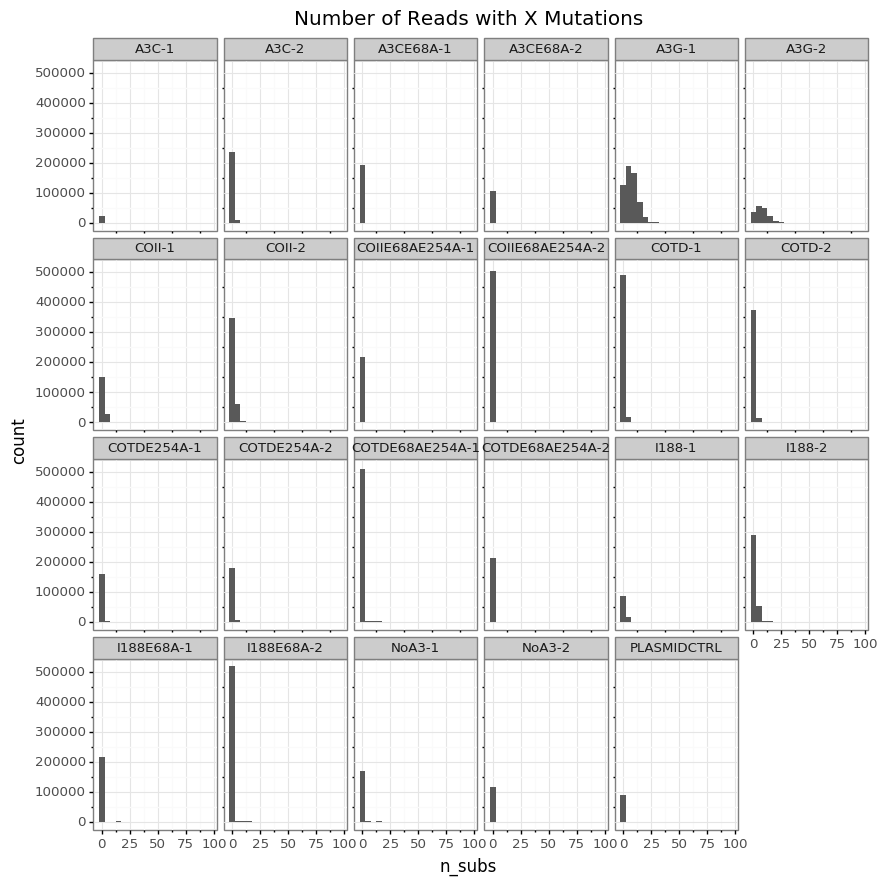

In [26]:
mut_count_plot = (ggplot(all_samples_df, aes(x='n_subs')) +
                  geom_histogram(binwidth=5) + 
                  facet_wrap('~ Sample', ncol=6) +
                  labs(title='Number of Reads with X Mutations') +
                  theme(axis_text_x=element_text(angle=0),
                        figure_size=(10, 10),
                       )
                  )
_ = mut_count_plot.draw()

### Make same plot as above, but frequency of reads for each sample with that number of substitutions.

In [115]:
all_sub_counts_df = pd.DataFrame()
rep1_sub_counts_df = pd.DataFrame()
rep2_sub_counts_df = pd.DataFrame()
for sample in df_samplenames:
    sample_binned_dict = {}
    sample_df = sub_count_dfs[sample]
    for i in range(0, 10):
        if i in sample_df['n_subs'].to_list():
            idx = sample_df.index[sample_df['n_subs'] == i][0]
            sample_binned_dict[str(i)] = sample_df.at[idx, 'n_sub_count']
        else:
            sample_binned_dict[str(i)] = 0
    sample_binned_dict['10+'] = sum(sample_df['n_sub_count']) - sum(sample_binned_dict.values())
    assert(sum(sample_df['n_sub_count']) == sum(sample_binned_dict.values()))
    sample_binned_df = pd.DataFrame.from_dict(sample_binned_dict, orient='index').reset_index().rename(columns={'index': 'n_subs', 0: 'n_sub_count'})
    sample_binned_df['n_sub_freq'] = sample_binned_df['n_sub_count'] / sum(sample_binned_df['n_sub_count']) * 100
    sample_binned_df['Sample'] = [sample.split('-')[0]]*len(sample_binned_df)
    if sample == 'PLASMIDCTRL':
        plasmid_binned_df = sample_binned_df
    elif '-1' in sample:
        rep1_sub_counts_df = rep1_sub_counts_df.append(sample_binned_df, ignore_index=True)
    elif '-2' in sample:
        rep2_sub_counts_df = rep2_sub_counts_df.append(sample_binned_df, ignore_index=True)
    else:
        print(f'Invalid sample name {sample}')
        break

reps_concat = pd.concat((rep1_sub_counts_df, rep2_sub_counts_df))
by_row_index = reps_concat.groupby(reps_concat.index)
reps_avg = by_row_index.mean()
reps_avg['n_subs'] = rep1_sub_counts_df['n_subs']
reps_avg['Sample'] = rep1_sub_counts_df['Sample']
        
all_sub_counts_df = pd.concat((reps_avg, plasmid_binned_df), ignore_index=True, sort=True)

display(all_sub_counts_df)

,Sample,n_sub_count,n_sub_freq,n_subs
0,NoA3,124595.5,85.785373,0
1,NoA3,15574.5,10.735875,1
2,NoA3,1920.5,1.325917,2
3,NoA3,417.0,0.284129,3
4,NoA3,211.0,0.144527,4
...,...,...,...,...
127,PLASMIDCTRL,0.0,0.000000,6
128,PLASMIDCTRL,2.0,0.002200,7
129,PLASMIDCTRL,2.0,0.002200,8
130,PLASMIDCTRL,0.0,0.000000,9


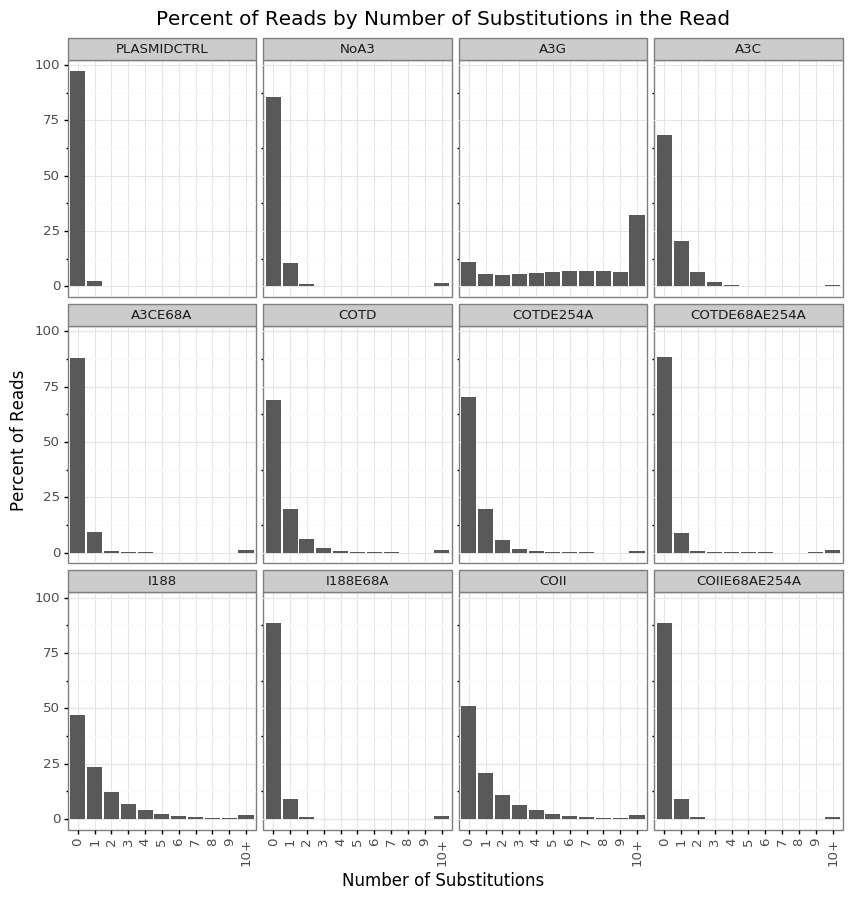

In [230]:
x_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
x_cat = pd.Categorical(all_sub_counts_df['n_subs'], categories=x_list)

facet_list = ["PLASMIDCTRL", 'NoA3', 'A3G', 'A3C', 'A3CE68A', 'COTD', 'COTDE254A', 'COTDE68AE254A',
              'I188', 'I188E68A', 'COII', 'COIIE68AE254A']
facet_cat = pd.Categorical(all_sub_counts_df['Sample'], categories=facet_list)

all_sub_counts_df = all_sub_counts_df.assign(x_cat = x_cat)
all_sub_counts_df = all_sub_counts_df.assign(facet_cat = facet_cat)

mut_freq_plot = (ggplot(all_sub_counts_df, aes(x='x_cat', y='n_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~ facet_cat', ncol=4) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of Substitutions') +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(10, 10),
                       )
                  )
_ = mut_freq_plot.draw()

### Plot subsets of graphs for Mollie:

Want to compare:
* No A3 vs A3G
* A3G vs COTD vs COII (called comp2)
* A3C vs COTD vs COTD 245 vs COTD 68 254 (called comp3)

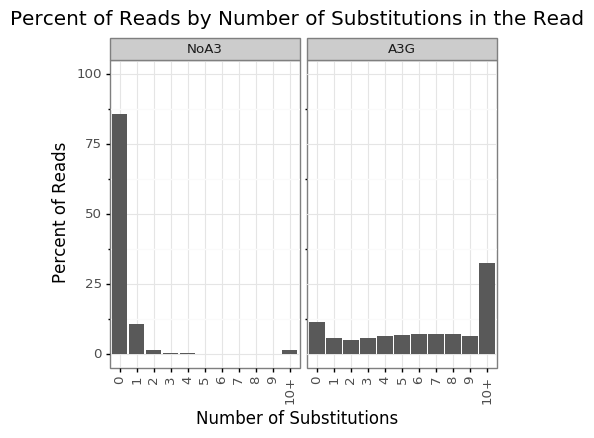

In [69]:
NoA3vsA3G = pd.concat([all_sub_counts_df[all_sub_counts_df['Sample'] == 'NoA3'], all_sub_counts_df[all_sub_counts_df['Sample'] == 'A3G']])
facet_list = ['NoA3', 'A3G']
facet_cat = pd.Categorical(NoA3vsA3G['Sample'], categories=facet_list)

NoA3vsA3G = NoA3vsA3G.assign(facet_cat = facet_cat)

mut_freq_plot = (ggplot(NoA3vsA3G, aes(x='x_cat', y='n_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~ facet_cat', ncol=4) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of Substitutions') +
                  ylim([0, 100]) +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(len(facet_list)*2.5, 4),
                       )
                  )
_ = mut_freq_plot.draw()

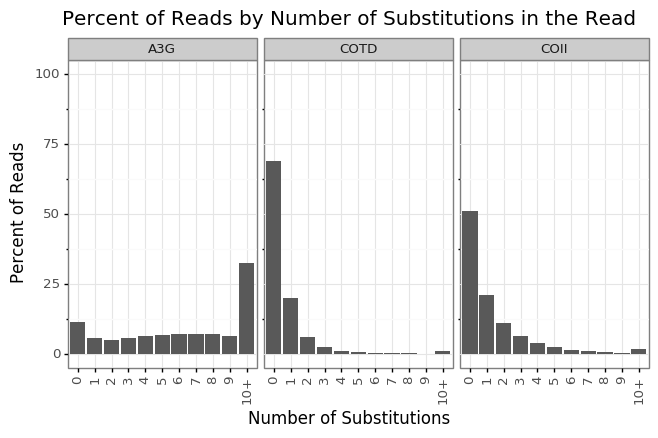

In [70]:
comp2 = pd.concat([all_sub_counts_df[all_sub_counts_df['Sample'] == 'A3G'], 
                   all_sub_counts_df[all_sub_counts_df['Sample'] == 'COTD'],
                   all_sub_counts_df[all_sub_counts_df['Sample'] == 'COII']])
facet_list = ['A3G', 'COTD', 'COII']
facet_cat = pd.Categorical(comp2['Sample'], categories=facet_list)

comp2 = comp2.assign(facet_cat = facet_cat)

mut_freq_plot = (ggplot(comp2, aes(x='x_cat', y='n_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~ facet_cat', ncol=4) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of Substitutions') +
                  ylim([0, 100]) +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(len(facet_list)*2.5, 4),
                       )
                  )
_ = mut_freq_plot.draw()

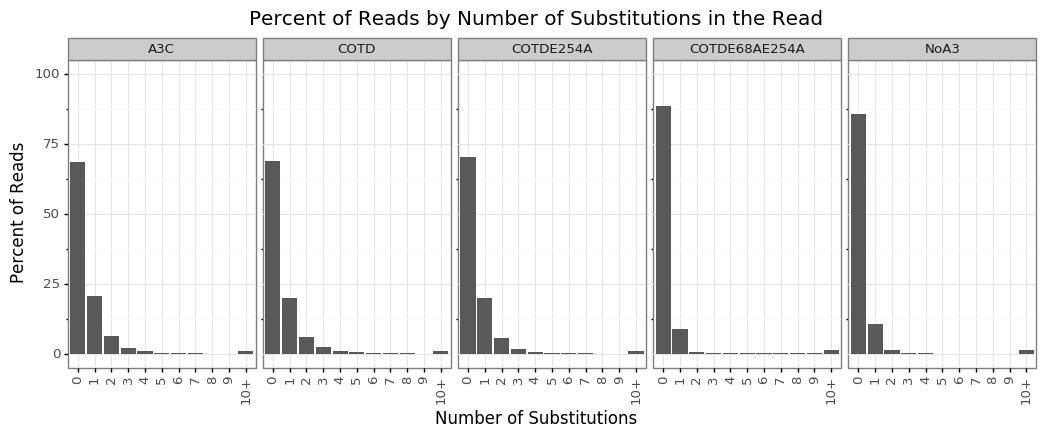

In [139]:
comp3 = pd.concat([all_sub_counts_df[all_sub_counts_df['Sample'] == 'A3C'], 
                   all_sub_counts_df[all_sub_counts_df['Sample'] == 'COTD'],
                   all_sub_counts_df[all_sub_counts_df['Sample'] == 'COTDE254A'],
                   all_sub_counts_df[all_sub_counts_df['Sample'] == 'COTDE68AE254A'],
                   all_sub_counts_df[all_sub_counts_df['Sample'] == 'NoA3']])
facet_list = ['A3C', 'COTD', 'COTDE254A', 'COTDE68AE254A', 'NoA3']
facet_cat = pd.Categorical(comp3['Sample'], categories=facet_list)

comp3 = comp3.assign(facet_cat = facet_cat)

mut_freq_plot = (ggplot(comp3, aes(x='x_cat', y='n_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~ facet_cat', ncol=5) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of Substitutions') +
                  ylim([0, 100]) +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(len(facet_list)*2.5, 4),
                       )
                  )
_ = mut_freq_plot.draw()

# Look at standard error of skewness and Kurtosis?

Calculating motif substitution frequencies...
Averaging frequencies...


,3',5',freq_avg,motif,sample,sub
0,A,A,0.000173,AAA,NoA3,AC
1,A,A,0.001089,AAA,NoA3,AG
2,A,A,0.000299,AAA,NoA3,AT
3,C,A,0.001478,AAC,NoA3,AC
4,C,A,0.001024,AAC,NoA3,AG
...,...,...,...,...,...,...
2103,A,G,0.004859,GTA,PLASMIDCTRL,TG
2104,C,G,0.002961,GTC,PLASMIDCTRL,TG
2105,G,G,0.005920,GTG,PLASMIDCTRL,TG
2106,T,G,0.006150,GTT,PLASMIDCTRL,TG


Making heatmaps...


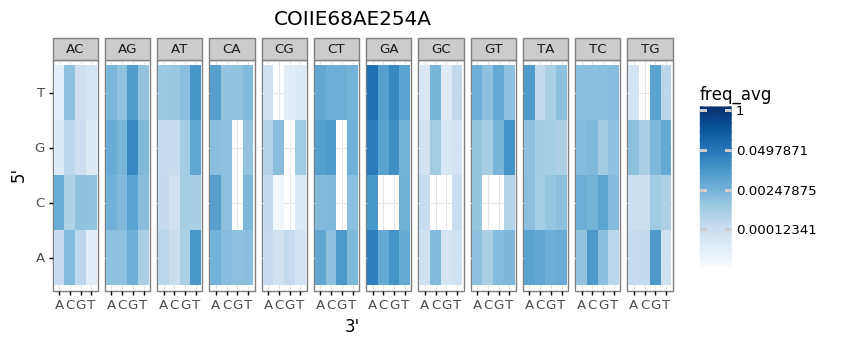

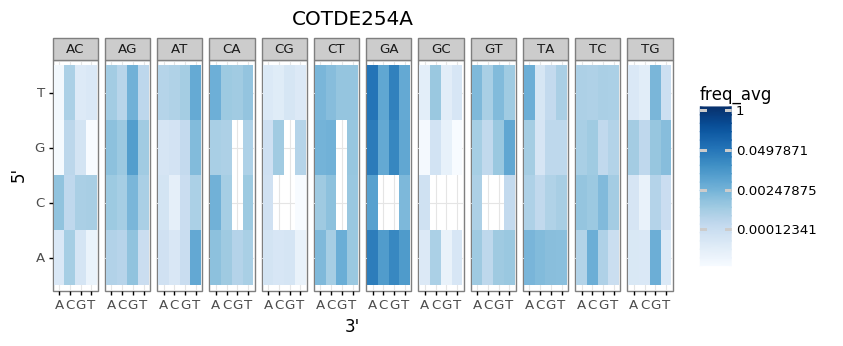

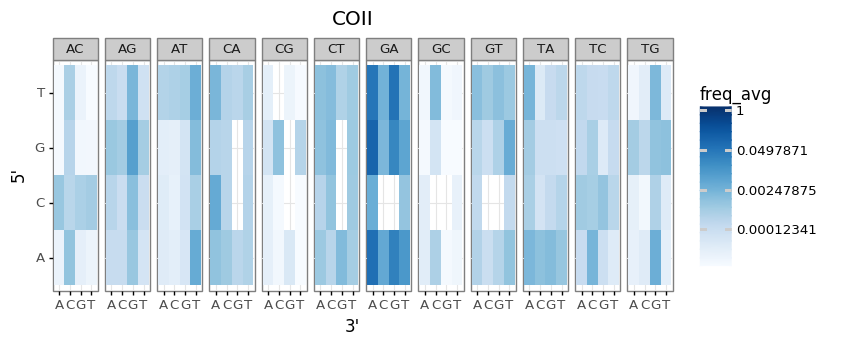

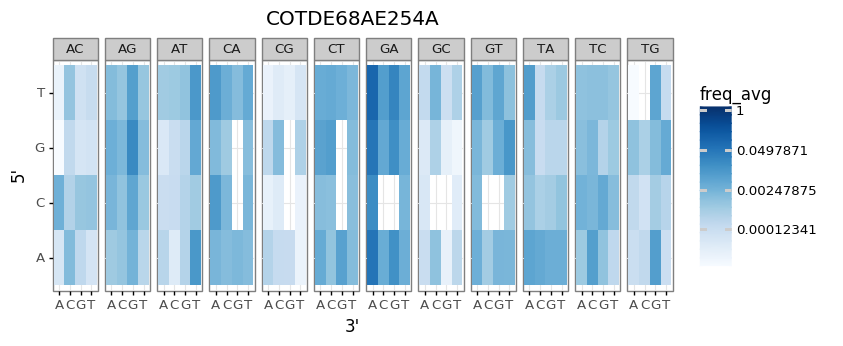

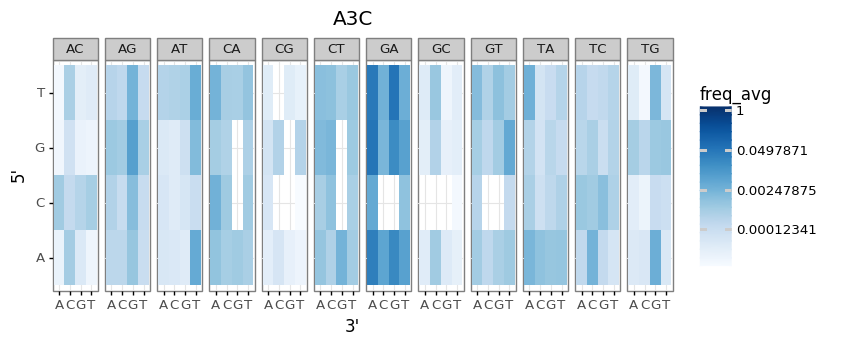

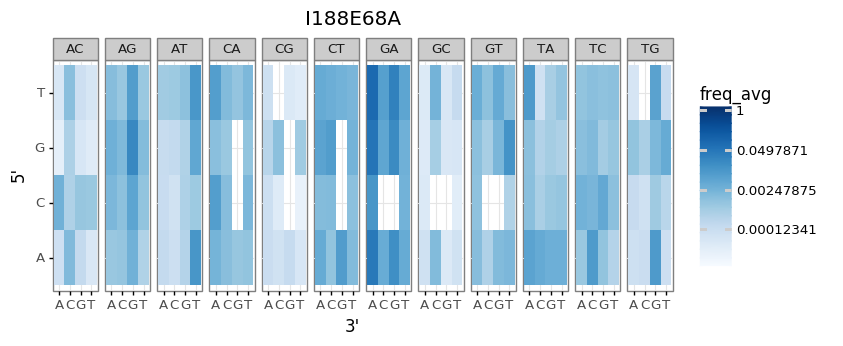

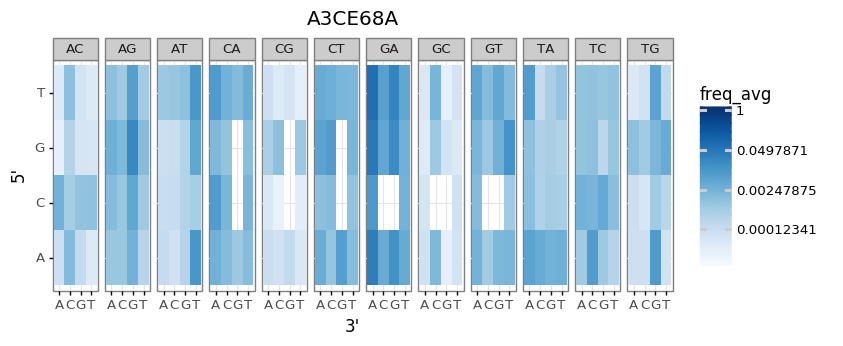

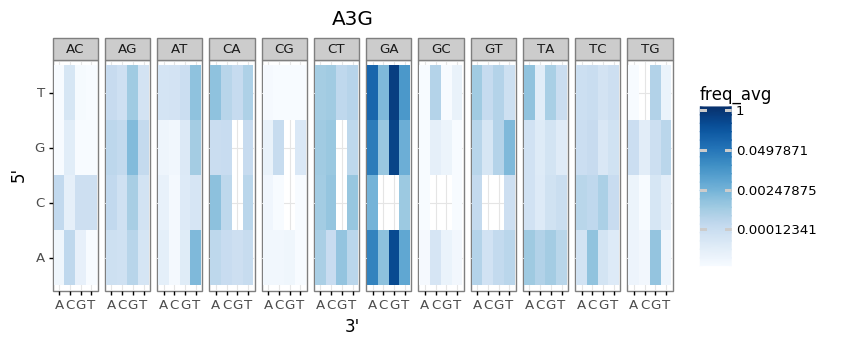

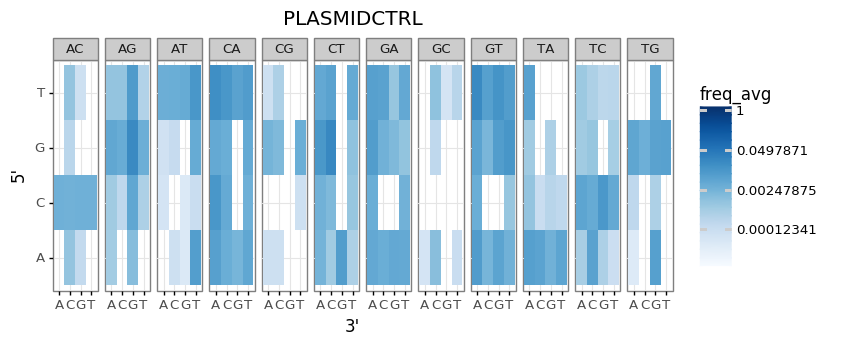

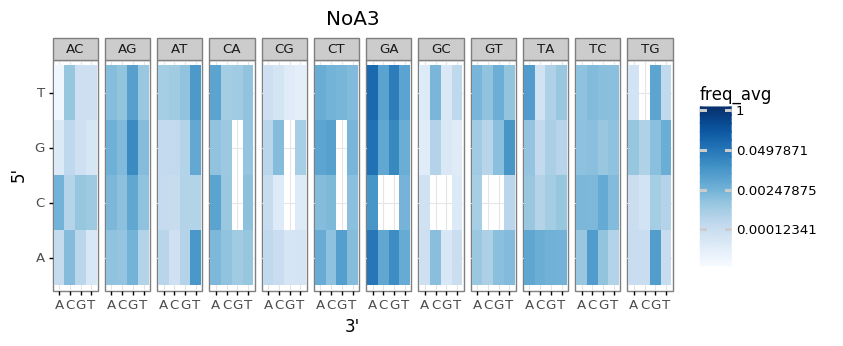

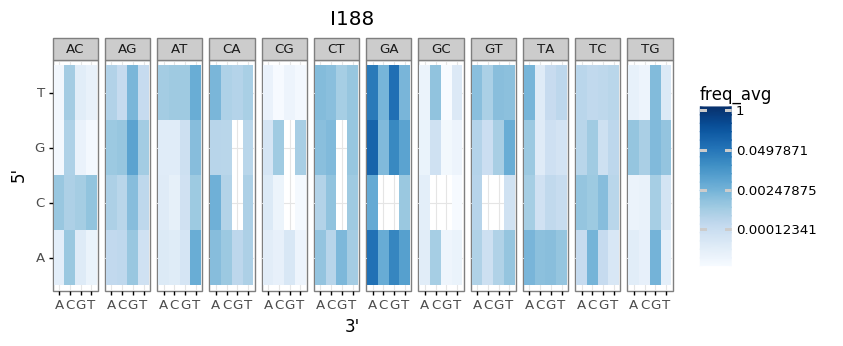

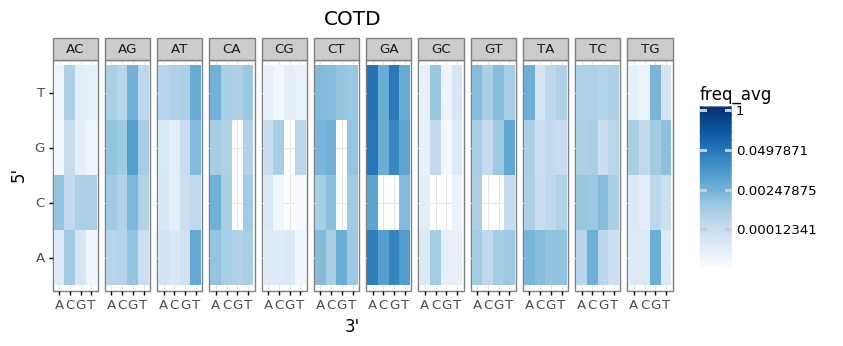

In [167]:
pseudocount = 1
all_samples_motif_freq_df = pd.DataFrame(columns=['sub', "5'", "3'", 'motif', 'sample'])
rep1_motif_counts_dict = {}
rep2_motif_counts_dict = {}
print(f"Calculating motif substitution frequencies...")
for sample in df_samplenames:
#   STOP STRATIFYING BY SUB NUMBER (comment out that code)
#     sample_df = onlysubs_dfs[sample]
#     low_sub = sample_df[sample_df['n_subs'] <= 10]
#     high_sub = sample_df[sample_df['n_subs'] > 10]
#     sample_subs_counts = pd.DataFrame(columns=['sub',"5'", "3'", 'motif', 'count', 'freq', 'sub_cat', 'sample'])
#     for sub_df, sub_cat in [(low_sub, 'low'), (high_sub, 'high')]:
    sub_df = onlysubs_dfs[sample]
    sample_motif_counts = pd.DataFrame(columns = ['sub',"5'", "3'", 'motif', 'count', 'freq', 'sample'])
    sub_info_list = [sub_tup for sub_tups in sub_df['sub_tups'].to_list() for sub_tup in sub_tups]
    sub_info_df = pd.DataFrame(sub_info_list, columns=["5'", 'sub', "3'", "motif"])
    sub_info_df_counts = pd.DataFrame({'count' : sub_info_df.groupby( ["sub", "5'", "3'", "motif"] ).size()}).reset_index()
#     sub_info_df_counts['sub_cat'] = [sub_cat]*len(sub_info_df_counts)
    sub_info_df_counts['count'] = sub_info_df_counts['count'].astype('int64')
    sub_info_df_counts['freq'] = ''
        # This calculates the frequency as the number of times a substitution in the middle of a motif occurs
        # divided by the number of times that motif was sequenced for this sample and sub_cat.
        # This is not a strict frequency of the # of times a motif was mutated because it depends on the substitution
        # If sequence AAAGGG was sequenced 10 times and motif AGA was mutated to AAA 2 times and ACA 5 times
        # and GGG was mutated to GAG 3 times and GTG 5 times, then the frequencies would be:
        # sub motif freq
        # GA   AGA   0.2
        # GC   AGA   0.5
        # GA   GGG   0.3
        # GT   GGG   0.5
        # Thus the sum of these frequencies can be > 1.
    for i in range(len(sub_info_df_counts)):
        m = sub_info_df_counts.iloc[i]['motif']
        sub_info_df_counts.at[i, 'freq'] = sub_info_df_counts.iloc[i]['count'] / (len(sub_df) * refseq_motif_counts[m] + pseudocount)
    sample_motif_counts = sample_motif_counts.append(sub_info_df_counts, ignore_index=True)
    sample_motif_counts['freq'] = sample_motif_counts['freq'].astype('float')
    sample_motif_counts['sample'] = sample
    if sample == 'PLASMIDCTRL':
        plasmid_motif_counts = sample_motif_counts
    elif '-1' in sample:
        rep1_motif_counts_dict[sample[:-2]] = sample_motif_counts
    elif '-2' in sample:
        rep2_motif_counts_dict[sample[:-2]] = sample_motif_counts
    else:
        print(f'Invalid sample name {sample}')
        break

print(f"Averaging frequencies...")
for samplename in rep1_motif_counts_dict:
    sample_reps_concat = pd.concat((rep1_motif_counts_dict[samplename], rep2_motif_counts_dict[samplename]))
    reps_freq_avg = sample_reps_concat.groupby(['motif', 'sub']).mean()
    reps_freq_avg = reps_freq_avg.add_suffix('_avg').reset_index()
    reps_freq_avg["5'"] = ''
    reps_freq_avg["3'"] = ''
    for i in range(len(reps_freq_avg)):
        reps_freq_avg.at[i, "5'"] = reps_freq_avg['motif'].iloc[i][0]
        reps_freq_avg.at[i, "3'"] = reps_freq_avg['motif'].iloc[i][2]
    reps_freq_avg['sample'] = [samplename]*len(reps_freq_avg)
    all_samples_motif_freq_df = all_samples_motif_freq_df.append(reps_freq_avg, ignore_index=True)
    
plasmid_motif_counts = plasmid_motif_counts.rename(columns={'freq': 'freq_avg'})
plasmid_motif_counts = plasmid_motif_counts[['sub', "5'", "3'", 'motif', 'sample', 'freq_avg']]
all_samples_motif_freq_df = all_samples_motif_freq_df.append(plasmid_motif_counts, ignore_index=True)
display(all_samples_motif_freq_df)

print('Making heatmaps...')
for sample in set(all_samples_motif_freq_df['sample'].to_list()):
    sample_motif_freq_df = all_samples_motif_freq_df[all_samples_motif_freq_df['sample'] == sample]
    heat_map = (ggplot(sample_motif_freq_df, aes("3'", "5'", fill='freq_avg')) + 
                geom_tile() +
                scale_fill_cmap(name='Blues', trans='log', limits=(1e-5, 1)) +
                facet_grid('~sub', labeller='label_value')+
                labs(title=f"{sample}")+
                theme(figure_size=(8, 3))
               )
    
    _heat_map = heat_map.draw()


### Make a heat_map that just looks at motifs for G->A substitutions across all samples

,3',5',freq_avg,motif,sample,sub
0,A,A,0.043230,AGA,NoA3,GA
1,C,A,0.004438,AGC,NoA3,GA
2,G,A,0.015984,AGG,NoA3,GA
3,T,A,0.003724,AGT,NoA3,GA
4,A,C,0.011107,CGA,NoA3,GA
...,...,...,...,...,...,...
163,T,G,0.001063,GGT,PLASMIDCTRL,GA
164,A,T,0.006469,TGA,PLASMIDCTRL,GA
165,C,T,0.005693,TGC,PLASMIDCTRL,GA
166,G,T,0.000911,TGG,PLASMIDCTRL,GA


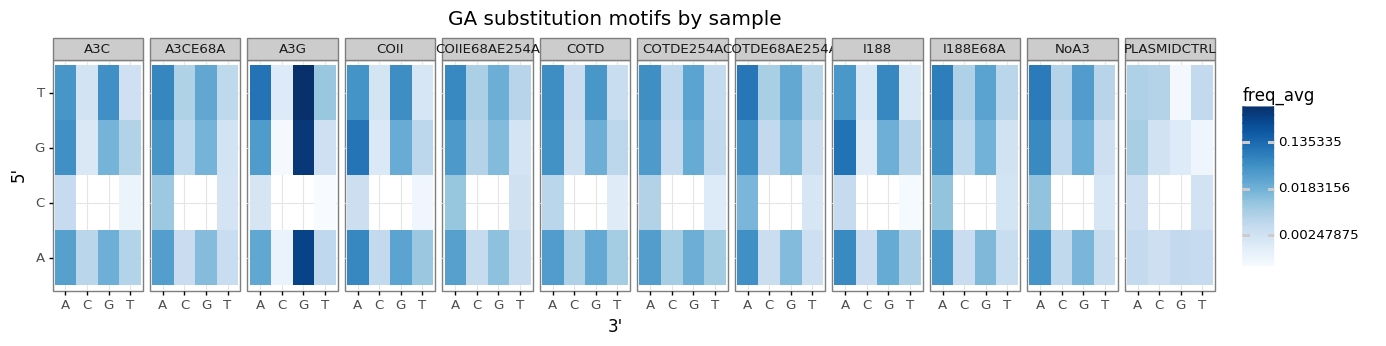

In [168]:
all_samples_ga = all_samples_motif_freq_df[all_samples_motif_freq_df['sub'] == 'GA'].reset_index(drop=True)
display(all_samples_ga)

heat_map = (ggplot(all_samples_ga, aes("3'", "5'", fill='freq_avg')) + 
            geom_tile() +
            scale_fill_cmap(name='Blues', trans='log') +
            facet_grid('~sample', labeller='label_value')+
            theme(figure_size=(15, 3)) +
            labs(title="GA substitution motifs by sample")              
           )

_heat_map = heat_map.draw()

### Make logo plots of motif preferences

In [108]:
import random
import matplotlib.pyplot as plt

import dmslogo
from dmslogo.colorschemes import CBPALETTE

,sample,letter,freq_avg,site,color
0,A3C,A,0.0607626,1,green
1,A3C,C,0.00523022,1,blue
2,A3C,G,0.0723302,1,black
3,A3C,T,0.0937937,1,red
4,A3CE68A,A,0.0529667,1,green
...,...,...,...,...,...
43,NoA3,T,0.0147723,3,red
44,PLASMIDCTRL,A,0.0213237,3,green
45,PLASMIDCTRL,C,0.0116149,3,blue
46,PLASMIDCTRL,G,0.00706091,3,black


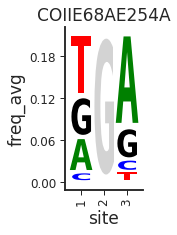

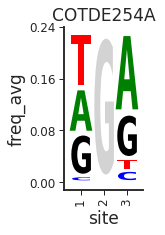

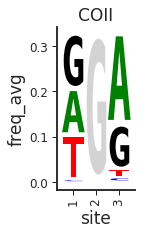

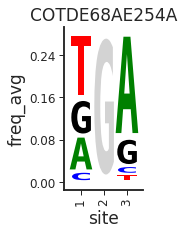

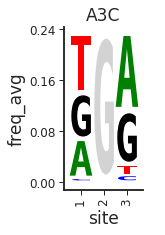

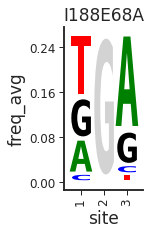

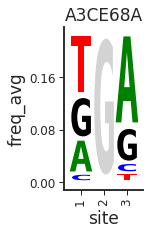

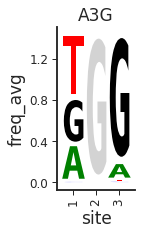

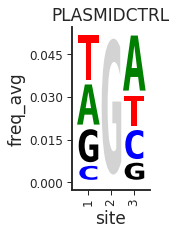

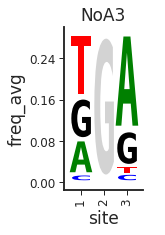

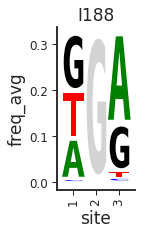

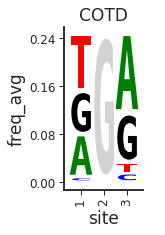

In [229]:
site1_logo_data = all_samples_ga.groupby(['sample', "5'"]).sum()
site1_logo_data = site1_logo_data.add_suffix('').reset_index()
site1_logo_data['site'] = [1]*len(site1_logo_data)
site1_logo_data['color'] = ['green', 'blue', 'black', 'red']*int((len(site1_logo_data)/4))
site1_logo_data = site1_logo_data.rename(columns={"5'": 'letter'})

site3_logo_data = all_samples_ga.groupby(['sample', "3'"]).sum()
site3_logo_data = site3_logo_data.add_suffix('').reset_index()
site3_logo_data['site'] = [3]*len(site3_logo_data)
site3_logo_data['color'] = ['green', 'blue', 'black', 'red']*int((len(site3_logo_data)/4))
site3_logo_data = site3_logo_data.rename(columns={"3'": 'letter'})

site2_logo_data = pd.DataFrame(columns=['sample', 'letter', 'freq_avg', 'site', 'color'])
site2_logo_data['sample'] = list(set(site3_logo_data['sample']))
site2_logo_data['letter'] = ['G']*len(site2_logo_data)
site2_logo_data['site'] = [2]*len(site2_logo_data)
site2_logo_data['color'] = ['lightgrey']*len(site2_logo_data)
for sample in site2_logo_data['sample']:
    idx = site2_logo_data[site2_logo_data['sample'] == sample].index
    summed_freq = site3_logo_data.groupby(['sample', 'site']).sum()
    summed_freq = summed_freq.add_suffix('').reset_index()
    j = summed_freq[summed_freq['sample'] == sample].index
    j = j[0]
    site2_logo_data.at[idx[0], 'freq_avg'] = summed_freq.at[j, 'freq_avg']

combined_logo_data = pd.concat([site1_logo_data, site2_logo_data, site3_logo_data], sort=False)
display(combined_logo_data)

for sample in set(combined_logo_data['sample']):
    sample_logo_data = combined_logo_data[combined_logo_data['sample'] == sample]
    fig, ax = dmslogo.draw_logo(data=sample_logo_data,
                            x_col='site',
                            letter_col='letter',
                            letter_height_col='freq_avg',
                            color_col='color',
                            title=sample)

## Parse bcinfo files into codon variant tables
I will use [dms_tools2.utils.barcodeInfoToCodonVariantTable](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.barcodeInfoToCodonVariantTable) to parse the /codoncounts/(sample)_bcinfo.txt.gz. files into codon variant tables. 


# New plan:
Alternatively, the /codoncounts/(sample)_bcinfo.txt.gz files (viewed at the end of this notebook) output by bcsubamp could be directly parsed using getSubstitions. 

In [ ]:
# trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
# samplenames2 = ["PLASMIDCTRL", "NoA3-1", "A3G-1", "A3C-1", "A3CE68A-1", "COTD-1", "COTDE254A-1", "COTDE68AE254A-1", "I188-1", "I188E68A-1", "COII-1", "COIIE68AE254A-1", "NoA3-2", "A3G-2", "A3C-2", "A3CE68A-2", "COTD-2", "COTDE254A-2", "COTDE68AE254A-2", "I188-2", "I188E68A-2", "COII-2", "COIIE68AE254A-2"]
# samplebcinfofiles = []
# for name in samplenames2:
#     templist=[]
#     templist.append("{0}/{1}".format(countsdir, name))
#     samplebcinfofiles.append(templist)
# bcinfo_dict = {}

# # Create a zip object from two lists
# zipbObj = zip(samplenames2, samplebcinfofiles)
 
# # Create a dictionary from zip object
# bcinfo_dict = dict(zipbObj)

# bcinfo_dict

In [ ]:
# #we must use a "wildtype" reference sequnce that is the same length as the sequencing?
# #below is the sequence in "./data/Trimmed_Bru_Pol.fasta"
# trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
# variants = barcodeInfoToCodonVariantTable(bcinfo_dict, trimmedrefseq)

In [ ]:
#variants_nt = dms_variants.codonvarianttable()

In [ ]:
# import matplotlib
# import matplotlib.pyplot as plt
# plt.ion()

# from IPython.display import display

# from epistasis.pyplot import nonlinear



In [ ]:
# p = variants.plotMutFreqs(variant_type='all', mut_type='codon', heightscale=1.9)
# _ = p.draw()

In [ ]:
# p = variants.plotNumMutsHistogram('codon', samples=None)
# display(p)